# Notebook de prueba

Este notebook es un ejemplo cómo procesar y utilizar los datos de entrenamiento y de prueba para la competición https://www.kaggle.com/competitions/playground-series-s4e9/ de la práctica 3 de Inteligencia de Negocio. 

Es un ejemplo que es claramente mejorable, se deja a el/la estudiante el mejorarlo para obtener mejores resultados.

## Carga de librería

Lo primero es cargar las librerías.

In [1]:
import pandas as pd

import numpy as np

import seaborn as sns

from matplotlib import pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor



## Lectura de datos

Ahora leemos los datos.

In [2]:
train = pd.read_csv("train.csv", na_values="NaN", sep = ",") # Definimos na_values para identificar bien los valores perdidos
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


In [3]:
train.columns

Index(['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price'],
      dtype='object')

## Visualización

Vamos a hacer unas ligeras visualizaciones de ejemplo.

Ahora visualizo los precios de venta en el conjunto de entrenamiento.

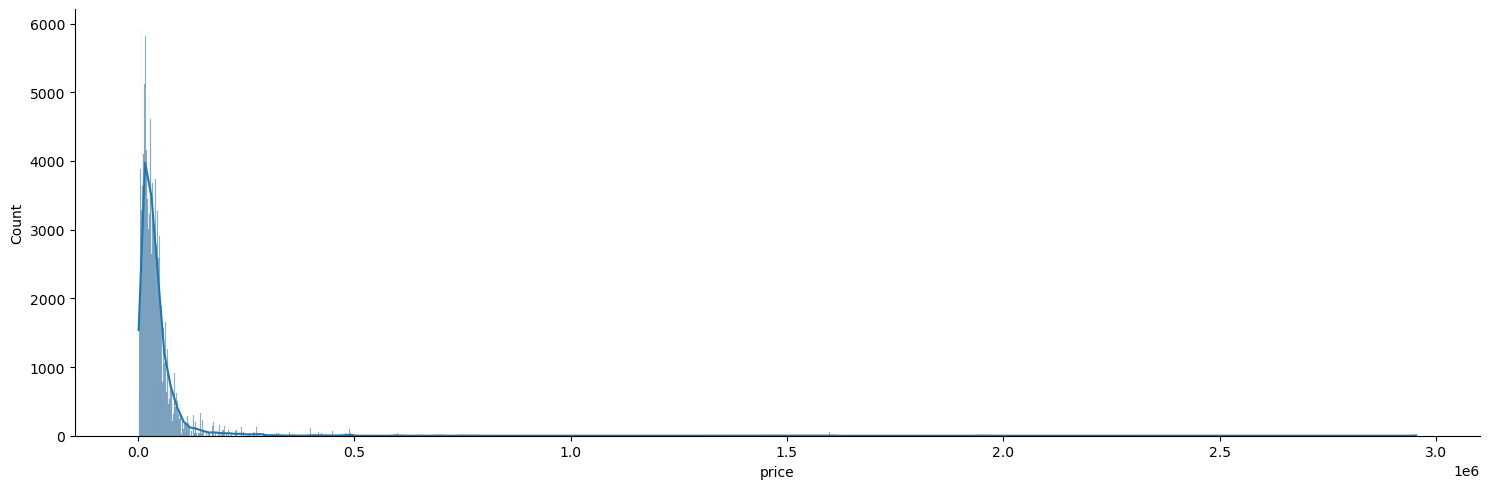

In [4]:
sns.displot(data=train, x="price", aspect=3, kde=True)

Ahora visualizamos cómo cambia la distribución (usando un boxplot) según otro atributo, en este caso nos quedamos con un subconjunto de marcas

In [5]:
marcas = train[train['brand'].str.contains('MINI|BMW|Nissan', regex = True) ]


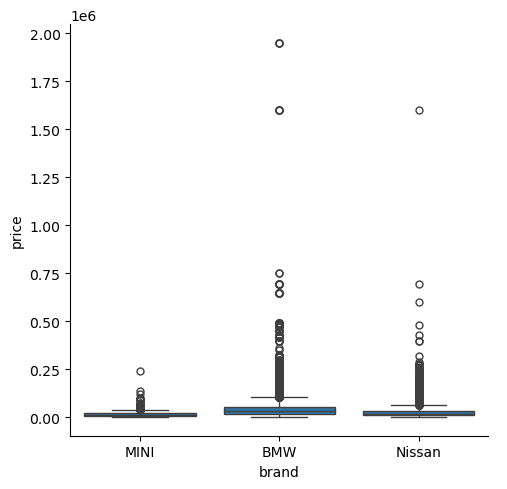

In [6]:

sns.catplot(data=marcas, y="price", x='brand', kind="box")


## Procesar datos

Vamos a procesar datos:
- Valores perdidos.
- Etiquetado.

Primero quito el Id de train que no me sirve de nada, y complica el etiquetado. También la quito de test pero antes lo guardo (para el fichero de salida)

In [7]:
if 'id' in train:
    train.drop('id', axis=1, inplace=True)

In [8]:
test = pd.read_csv("test.csv", na_values="NaN")
test_ids = test.id
test = test.drop('id', axis=1)

Concateno la entrada de ambos para los procesos de etiquetado, que aprenda con ambos conjuntos

In [9]:
input_all = pd.concat([train.drop('price', axis=1), test])

In [10]:
input_all.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title'],
      dtype='object')

Ahora selecciono los atributos de tipo categórico (los que no son numéricos)

In [11]:
col_cat = list(input_all.select_dtypes(exclude=np.number).columns)

In [12]:
col_cat

['brand',
 'model',
 'fuel_type',
 'engine',
 'transmission',
 'ext_col',
 'int_col',
 'accident',
 'clean_title']

Compruebo que son realmente categóricos.

In [13]:
input_all[col_cat].head()

,brand,model,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,MINI,Cooper S Base,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes
1,Lincoln,LS V8,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes
2,Chevrolet,Silverado 2500 LT,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes
3,Genesis,G90 5.0 Ultimate,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes
4,Mercedes-Benz,Metris Base,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes


## Proceso valores perdidos

In [14]:
test.isnull().sum()

brand               0
model               0
model_year          0
milage              0
fuel_type        3383
engine              0
transmission        0
ext_col             0
int_col             0
accident         1632
clean_title     14239
dtype: int64

In [15]:
train.isnull().sum()

brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

Hay valores perdidos tanto en el conjunto de entrenamiento como en el de test.

Voy a reemplazar los valores categóricos por el más frecuente (es mejorable)

In [16]:
imputer_cat = SimpleImputer(strategy="most_frequent")
imputer_cat.fit(input_all[col_cat])
train[col_cat] = imputer_cat.transform(train[col_cat])
test[col_cat] = imputer_cat.transform(test[col_cat])

Compruebo que la variable objetivo no tenga valores nulos. Si fuese el caso habría que borrar dichas instancias.

In [17]:
train.price.isnull().sum()

0

Ahora reemplazo los valores numéricos por la mediana.

In [18]:
col_num = list(train.select_dtypes(include=np.number).columns)
col_num.remove('price')
imputer_num = SimpleImputer(strategy="median")
imputer_num.fit(input_all[col_num])
train[col_num] = imputer_num.transform(train[col_num])
test[col_num] = imputer_num.transform(test[col_num])

## Hago el etiquetado

Ahora hago el etiquetado con LabelEncoder, usando un diccionario de LabelEncoder

In [19]:
labelers = {}
test_l = test.copy()
train_l = train.copy()

for col in col_cat:
    labelers[col] = LabelEncoder().fit(input_all[col])
    test_l[col] = labelers[col].transform(test[col])
    train_l[col] = labelers[col].transform(train[col])


In [20]:
train_l.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,31,495,2007.0,213000.0,2,116,38,312,71,1,0,4200
1,28,930,2002.0,143250.0,2,367,38,263,10,0,0,4999
2,9,1575,2002.0,136731.0,1,641,38,38,71,1,0,13900
3,16,758,2017.0,19500.0,2,864,49,29,14,1,0,45000
4,36,1077,2021.0,7388.0,2,260,23,29,10,1,0,97500


Compruebo que estén todos los atributos

In [21]:
assert((train_l.columns == train.columns).all())

## Ahora preparo los conjuntos de entrenamiento y test

Defino en X_train los valores sin el atributo a predecir, y. 

También voy a eliminar el Id de entrenamiento que es problemático, pero lo guardo para el fichero de salida.


In [22]:
y_train = train_l.price
X_train = train_l.drop('price', axis=1)

if 'id' in test_l:
    test_l.drop('id', axis=1, inplace=True)

X_test = test_l

## Aplico modelo

#### Árbol de decisión.

In [23]:
model = DecisionTreeRegressor()

Uso la métrica que aplica la competición. Los modelos tienden a maximizar, por eso la métrica de error tiene signo negativo.

In [24]:
values = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
print(values)
print(values.mean())

[-110716.4563372  -120338.39824578 -121823.50319403  -99629.01924693
 -110858.59460002]
-112673.19432479318


Ahora vamos a entrenar con todo el conjunto de entrenamiento

In [25]:
model.fit(X_train, y_train)

DecisionTreeRegressor()

Ahora predigo.

In [26]:
pred = model.predict(X_test)

In [27]:
pred2 = model.predict(X_train)

In [28]:
rmse = np.sqrt(mean_squared_error(y_train, pred2))
print(rmse)

4938.98611151374


Guardo el fichero de salida para evaluar:

In [29]:
salida = pd.DataFrame({'id': test_ids, 'price': pred})

In [30]:
salida.to_csv("Prueba2.csv", index=False)

Ahora se puede subir el nuevo fichero a la competición.

### Algoritmo Random Forest

In [26]:
randomforest_model = RandomForestRegressor(
    max_depth=8, 
    min_samples_split=10, 
    min_samples_leaf=5, 
    n_jobs=-1, 
    n_estimators=500, 
    random_state=42,
)

##### Métricas

In [27]:
values = cross_val_score(randomforest_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
print(values)
print(values.mean())

[-71524.41009175 -76962.41444932 -75638.83313423 -66360.97687181
 -75353.25644626]
-73167.97819867342


##### Entrenamiento del modelo

In [28]:
randomforest_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, min_samples_leaf=5, min_samples_split=10,
                      n_estimators=500, n_jobs=-1, random_state=42)

##### Predigo y calculo las métricas

In [29]:
pred1 = randomforest_model.predict(X_test)

In [30]:
pred2 = randomforest_model.predict(X_train)

In [31]:
rmse = np.sqrt(mean_squared_error(y_train, pred2))
print(rmse)

70293.31106503053


##### Genero el archivo para la subida a la competición 

In [32]:
salida = pd.DataFrame({'id': test_ids, 'price': pred1})

In [33]:
salida.to_csv("Prueba4.csv", index=False)

#### Algoritmo LightGBM

In [84]:
lgb_model = lgb.LGBMRegressor(
    n_estimators=1000,          
    learning_rate=0.01,         
    max_depth=-1,               
    num_leaves=31,              
    min_data_in_leaf=20,        
    feature_fraction=0.8,       
    bagging_fraction=0.8,       
    bagging_freq=5,             
    lambda_l1=1.0,              
    lambda_l2=1.0,              
    random_state=42,            
    n_jobs=-1                  
)


##### Métricas

In [85]:
values = cross_val_score(lgb_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
print(values)
print(values.mean())

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Cu

In [86]:
lgb_model.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Cu

LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, feature_fraction=0.8,
              lambda_l1=1.0, lambda_l2=1.0, learning_rate=0.01,
              min_data_in_leaf=20, n_estimators=1000, n_jobs=-1,
              random_state=42)

In [87]:
pred1 = lgb_model.predict(X_test) 

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [88]:
pred2 = lgb_model.predict(X_train)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [89]:
rmse = np.sqrt(mean_squared_error(y_train, pred2))
print(rmse)

69618.76869315044


In [90]:
salida = pd.DataFrame({'id': test_ids, 'price': pred1})

In [91]:
salida.to_csv("Prueba6.csv", index=False)

#### Algoritmo XGBoost


In [94]:
xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=8,
    random_state=42
)

In [95]:
values = cross_val_score(xgb_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
print(values)
print(values.mean())

[-73012.94439775 -77407.62953897 -77329.2647941  -66943.88372162
 -76689.0225467 ]
-74276.54899982798


In [96]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [99]:
pred1 = xgb_model.predict(X_test) 

In [100]:
pred2 = xgb_model.predict(X_train)

In [101]:
rmse = np.sqrt(mean_squared_error(y_train, pred2))
print(rmse)

58324.085368364846


In [102]:
salida = pd.DataFrame({'id': test_ids, 'price': pred1})

In [103]:
salida.to_csv("Prueba7.csv", index=False)

#### Algortimo H2O

In [ ]:
import h2o
from h2o.automl import H2OAutoML
import pandas as pd

In [ ]:
h2o.init()

In [ ]:
h2o.estimators.xgboost.H2OXGBoostEstimator.available()

In [ ]:
import pandas as pd
from h2o.frame import H2OFrame

# Cargar el archivo con pandas
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")


train = H2OFrame(df_train)
test = H2OFrame(df_test)

In [ ]:
y = "price"
x = train.columns
x.remove(y)

In [ ]:
aml = H2OAutoML(max_runtime_secs=20000, seed=42)
aml.train(x=x, y=y, training_frame=train)

In [ ]:
leaderboard_sorted = aml.leaderboard.as_data_frame().sort_values(by='rmse')
print(leaderboard_sorted)

leaderboard_sorted.to_csv("leaderboard.csv", index=False)

In [ ]:
h2o.init()

# ID del modelo que deseas cargar
model_id = 'StackedEnsemble_Best1000_1_AutoML_2_20241228_232148'

# Verifica si el modelo existe en el servidor
available_models = h2o.ls()  # Lista los objetos en el servidor
if model_id in available_models['key'].values:
    # Carga el modelo si existe
    model = h2o.get_model(model_id)
    print(model)
else:
    print(f"El modelo con ID '{model_id}' no existe en el servidor H2O.")

In [ ]:
predictions = aml.leader.predict(test)

In [ ]:
predictions_df = predictions.as_data_frame()
test_ids = test["id"].as_data_frame()

submission = pd.DataFrame({
    'id': test_ids['id'],
    'price': predictions_df['predict']
})

# Guardar el archivo de salida
submission_path = 'Prueba2h2o.csv'  # Ruta del archivo de salida
submission.to_csv(submission_path, index=False)

#### Algoritmo CatBoost

In [42]:
catboost_model = CatBoostRegressor(
    iterations=200,
    learning_rate=0.05,
    depth=8,
    random_state=42,
)


In [43]:
values = cross_val_score(catboost_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
print(values)
print(values.mean())

0:	learn: 78686.3414211	total: 14.7ms	remaining: 2.92s
1:	learn: 78273.4253549	total: 28.5ms	remaining: 2.82s
2:	learn: 77904.1021189	total: 42.8ms	remaining: 2.81s
3:	learn: 77565.5315870	total: 58ms	remaining: 2.84s
4:	learn: 77248.3430426	total: 72.2ms	remaining: 2.81s
5:	learn: 76957.3150180	total: 87.1ms	remaining: 2.82s
6:	learn: 76695.5933930	total: 102ms	remaining: 2.8s
7:	learn: 76440.2556523	total: 115ms	remaining: 2.77s
8:	learn: 76214.5162961	total: 130ms	remaining: 2.75s
9:	learn: 75998.0847390	total: 145ms	remaining: 2.75s
10:	learn: 75805.1048155	total: 160ms	remaining: 2.75s
11:	learn: 75633.1878299	total: 174ms	remaining: 2.73s
12:	learn: 75466.4605032	total: 191ms	remaining: 2.74s
13:	learn: 75303.3126387	total: 205ms	remaining: 2.73s
14:	learn: 75157.7882499	total: 236ms	remaining: 2.9s
15:	learn: 75018.3646122	total: 251ms	remaining: 2.89s
16:	learn: 74893.2745968	total: 265ms	remaining: 2.85s
17:	learn: 74792.7892833	total: 280ms	remaining: 2.83s
18:	learn: 74685.8

In [44]:
catboost_model.fit(X_train, y_train)

0:	learn: 78370.2026806	total: 19.3ms	remaining: 3.83s
1:	learn: 77954.6129667	total: 37.4ms	remaining: 3.71s
2:	learn: 77577.2856731	total: 54.7ms	remaining: 3.59s
3:	learn: 77226.1886212	total: 71.2ms	remaining: 3.49s
4:	learn: 76901.7148748	total: 91.1ms	remaining: 3.55s
5:	learn: 76606.9328281	total: 112ms	remaining: 3.62s
6:	learn: 76345.5154306	total: 137ms	remaining: 3.79s
7:	learn: 76086.7436836	total: 163ms	remaining: 3.91s
8:	learn: 75855.3941897	total: 188ms	remaining: 4s
9:	learn: 75655.7186156	total: 216ms	remaining: 4.1s
10:	learn: 75460.7559809	total: 237ms	remaining: 4.06s
11:	learn: 75280.3086209	total: 259ms	remaining: 4.05s
12:	learn: 75117.8523216	total: 281ms	remaining: 4.04s
13:	learn: 74958.9057446	total: 302ms	remaining: 4.01s
14:	learn: 74811.4489801	total: 322ms	remaining: 3.97s
15:	learn: 74675.3729126	total: 343ms	remaining: 3.94s
16:	learn: 74548.1764981	total: 363ms	remaining: 3.9s
17:	learn: 74429.0261980	total: 388ms	remaining: 3.92s
18:	learn: 74320.939

In [45]:
pred1 = catboost_model.predict(X_test) 

In [46]:
pred2 = catboost_model.predict(X_train)

In [47]:
rmse = np.sqrt(mean_squared_error(y_train, pred2))
print(rmse)

71014.27823154547


In [48]:
salida = pd.DataFrame({'id': test_ids, 'price': pred1})

In [49]:
salida.to_csv("Prueba8.csv", index=False)

#### Algoritmo ElasticNet

In [52]:
from sklearn.linear_model import ElasticNet

elastic_net_model = ElasticNet(alpha=1.0, l1_ratio=0.5)

In [53]:
values = cross_val_score(elastic_net_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
print(values)
print(values.mean())

[-73341.12919121 -78285.23546727 -77060.67183323 -68107.3231575
 -76840.68274918]
-74727.00847967909


In [54]:
elastic_net_model.fit(X_train, y_train)

ElasticNet()

In [55]:
pred1 = elastic_net_model.predict(X_test) 

In [57]:
pred2 = elastic_net_model.predict(X_train)

In [58]:
rmse = np.sqrt(mean_squared_error(y_train, pred2))
print(rmse)

74814.15136341173


In [59]:
salida = pd.DataFrame({'id': test_ids, 'price': pred1})

In [60]:
salida.to_csv("Prueba9.csv", index=False)